### **Setup**

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!unzip training_images.zip -d training_images

In [ ]:
!unzip downloaded_images.zip -d downloaded_images

In [ ]:
DEFAULT_SIZE = [250, 250] 

def read_images(image_path='training_images', default_size=DEFAULT_SIZE):
    images = []
    labels = []
    directories = [image for image in os.listdir(image_path) if not image.startswith('.')]

    for image_dir in directories:
        img_path = os.path.join(image_path, image_dir)
        image_names = [image for image in os.listdir(img_path) if not image.startswith('.')]

        for image_name in image_names:
            image = Image.open (os.path.join(img_path, image_name))
            image = image.convert ("L") # convert to greyscale

            # resize if needed
            if (default_size is not None):
              image = image.resize(default_size , Image.ANTIALIAS)

            images.append(np.asarray(image , dtype =np. uint8))
            labels.append(image_dir)
            
    return [images, labels]

In [ ]:
def as_row_matrix(img):
    # empty case
    if len(img) == 0:
        return np.array([])
    # create empty matrix
    result_matrix = np.empty((0, img[0].size), dtype = img[0].dtype)
    # fill the matrix
    for row in img:
        result_matrix = np.vstack((result_matrix , np.asarray(row).reshape(1, -1)))
        
    return result_matrix

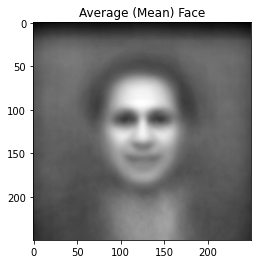

In [ ]:
[images, labels] = read_images()      
average_matrix = np.reshape(as_row_matrix(images).mean(axis=0), images[0].shape)
plt.imshow(average_matrix, cmap=plt.cm.gray)
plt.title("Average (Mean) Face")
plt.show()

In [ ]:
def components(eigenvalues, variance=.95):
    for num_components, eig_val_cs in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eig_val_cs > variance:
            return num_components
  
def pca(images, labels, numcomponents=0):
    [numrows, numcols] = images.shape

    if (numcomponents <= 0) or (numcomponents > numrows):
        numcomponents = numrows
        mu = images.mean(axis=0)
        images = images - mu

    if numrows > numcols:
        covariance_matrix = np.dot(images.T, images) 
        [eigenvalues, eigenvectors] = np.linalg.eigh(covariance_matrix)
    else :
        covariance_matrix = np.dot (images, images.T) 
        [eigenvalues, eigenvectors] = np.linalg.eigh(covariance_matrix)
        eigenvectors = np.dot(images.T, eigenvectors)
        for i in range (numrows):
            eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm( eigenvectors [:,i])

    # sort eigenvectors descending by their eigenvalue
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    num_components = components(eigenvalues)

    # select only num_components
    eigenvalues = eigenvalues[0: num_components].copy()
    eigenvectors = eigenvectors [:, 0:num_components].copy()
    return [eigenvalues, eigenvectors, mu]  

[eigenvalues, eigenvectors, mean] = pca(as_row_matrix(images), labels)

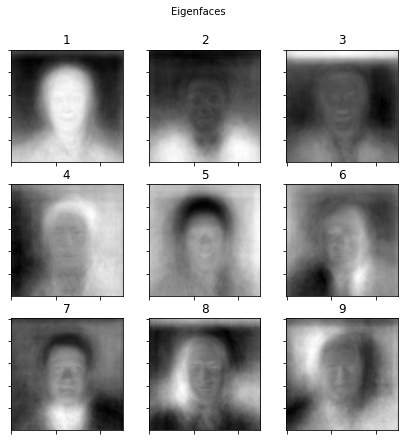

In [ ]:
def subplot(title, images, rows, cols, sptitles=[], colormap=plt.cm.gray, figsize=(7, 7)):
    fig = plt.figure(figsize = figsize)

    fig.text(.5, .95, title, horizontalalignment ="center")
    for i in range (len(images)):
        ax0 = fig.add_subplot(rows, cols, (i + 1))
        plt.setp(ax0.get_xticklabels(), visible=False)
        plt.setp(ax0.get_yticklabels(), visible=False)

        if len(sptitles) == len(images):
            plt.title(f'{str(sptitles[i])}')
        else:
            plt.title(f'{i+1}')

        plt.imshow(np.asarray(images[i]) , cmap = colormap)
    plt.show()
        
eigenfaces = []
minimum = eigenvectors.shape[1]
for i in range (min(minimum, 9)):
    eface = eigenvectors[:,i].reshape(images[0].shape)
    eigenfaces.append(np.asarray(eface))

subplot(title ="Eigenfaces", images=eigenfaces, rows=3, cols=3, colormap=plt.cm.gray)

In [ ]:
def project(subspace, images, mu):
    return np.dot(images - mu, subspace)

In [ ]:
def dist_metric(p,q):
    p = np.asarray(p).flatten()
    q = np.asarray(q).flatten()
    return np.sqrt(np.sum(np.power((p-q), 2)))

def predict (W, mu , projections, y, X):
    minDist = float("inf")
    minClass = -1
    Q = project (W, X.reshape(1 , -1), mu)
    for i in range (len(projections)):
        dist = dist_metric(projections[i], Q)
        if dist < minDist:
            minDist = dist
            minClass = i
    return minClass

projections = []
for xi in images:
    projections.append(project(eigenvectors, xi.reshape(1 , -1) , mean))


Mode 1

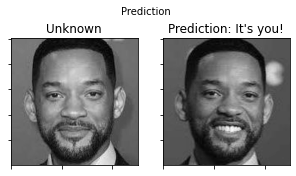

---
Seems like we guessed your photo :)
Are we right? :)
---


In [ ]:
for img in ['unknown1.jpg', 'unknown2.jpg', 'unknown3.jpg']:
  image = Image.open(img)
  image = image.convert ("L")

  if (DEFAULT_SIZE is not None ):
    image = image.resize (DEFAULT_SIZE , Image.ANTIALIAS )
  test_image = np. asarray (image , dtype =np. uint8 )
  predicted = predict(eigenvectors, mean , projections, labels, test_image)

  if labels[predicted] == 'Your_Photo':
    subplot(title ="Prediction", images =[test_image, images[predicted]], rows =1, cols =2, sptitles = ["Unknown", f"Prediction: It's you!"] , colormap=plt.cm.gray, figsize = (5,2.7))
    print('---')
    print('Seems like we guessed your photo :)')
    print('Are we right? :)')
    print('---')